In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns

import json

from fycharts.SpotifyCharts import SpotifyCharts
import sqlalchemy

import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

from datetime import datetime
from sklearn.model_selection import train_test_split

import statsmodels.api as sm

# We are required to do this in order to avoid "FutureWarning" issues.
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARIMA, ARMA
from statsmodels.tsa.stattools import adfuller  

from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

%matplotlib inline

import warnings
warnings.simplefilter(action="ignore")

In [15]:
pwd

'/Users/emilynaftalin/Data_Science/General Assembly/dsi/capstone/code'

**Reading in data for each country- 2017-2019; 2020**

In [2]:
italy_17_19 = pd.read_pickle('../data/it_17_19_v50_feat.pkl')
spain_17_19 = pd.read_pickle('../data/sp_17_19_v50_feat.pkl')
greece_17_19 = pd.read_pickle('../data/gr_17_19_v50_feat.pkl')

In [3]:
italy_20 = pd.read_pickle('../data/it_20_v50_feat.pkl')
spain_20 = pd.read_pickle('../data/sp_20_v50_feat.pkl')
greece_20 = pd.read_pickle('../data/gr_20_v50_feat.pkl')

In [4]:
spain_20.tail()

,Position,Track Name,Artist,region,spotify_id,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
date,,,,,,,,,,,,,,,,,,
2021-02-13,46,Hasta Abajo,Kevin Roldan,es,4PEfJZpVjdclfzZ9XO8uDw,0.714,0.671,5,-5.119,1,0.3620,0.28900,0.000000,0.3250,0.6410,169.732,229827,4
2021-02-13,47,Strange (feat. Hillary Smith),Kris Bowers,es,2bPWLtJe3v33z1j40sWB8a,0.251,0.150,2,-15.076,1,0.0342,0.98900,0.972000,0.1130,0.0727,70.453,198640,4
2021-02-13,48,Hecha Pa' Mi,Boza,es,3VvA1wSxukMLsvXoXtlwWx,0.725,0.756,4,-5.013,1,0.0572,0.36200,0.000685,0.1030,0.8280,100.070,186133,4
2021-02-13,49,La Luz - A COLORS SHOW,María José Llergo,es,5jRnVQbjB6qgN3MARS4xw7,0.722,0.357,9,-10.487,0,0.0996,0.81400,0.155000,0.0863,0.6410,149.895,191599,4
2021-02-13,50,Boku no Sensou - TV Size,Shinsei Kamattechan,es,3tRPfCFAEv6wWyQO0YnGGV,0.447,0.891,9,-4.776,1,0.0788,0.00447,0.000905,0.3900,0.5170,143.976,90960,4


**Resampling by month**

_`rm` denotes resampling by month._ 

In [5]:
rm_italy_17_19 = italy_17_19.resample("M").mean()
rm_spain_17_19 = spain_17_19.resample("M").mean()
rm_greece_17_19 = greece_17_19.resample("M").mean()

In [6]:
rm_italy_20 = italy_20.resample("M").mean()
rm_spain_20 = spain_20.resample("M").mean()
rm_greece_20 = greece_20.resample("M").mean()

**Resampling by week**

_`rw` denotes resampling by week._ 

In [7]:
rw_italy_17_19 = italy_17_19.resample("W").mean()
rw_spain_17_19 = spain_17_19.resample("W").mean()
rw_greece_17_19 = greece_17_19.resample("W").mean()

In [8]:
rw_italy_20 = italy_20.resample("W").mean()
rw_spain_20 = spain_20.resample("W").mean()
rw_greece_20 = greece_20.resample("W").mean()

# SARIMAX model 

### Dickey-Fuller and Differencing 

Augmented Dickey-Fuller test to estimate whether data are stationary. 

In [13]:
audio_features = [
'danceability', 
 'energy',
 'key',
 'loudness',
 'mode',
 'speechiness',
 'acousticness',
 'instrumentalness',
 'liveness',
 'valence',
 'tempo']

In [9]:
# Code by Joseph Nelson! 

def interpret_dftest(dftest):
    dfoutput = pd.Series(dftest[0:2], index=['Test Statistic', 'p-value'])
    return dfoutput

_Dickey-Fuller on original dataframes_

In [11]:
interpret_dftest(adfuller(rw_italy_17_19['acousticness']))

Test Statistic   -4.783946
p-value           0.000058
dtype: float64

In [12]:
interpret_dftest(adfuller(rw_italy_17_19['valence']))

Test Statistic   -2.009585
p-value           0.282386
dtype: float64

In [15]:
for feature in audio_features:
    print(f'Dickey-Fuller Interpretation for {feature}:\n{interpret_dftest(adfuller(rw_italy_17_19[feature]))}')

Dickey-Fuller Interpretation for danceability:
Test Statistic   -2.757635
p-value           0.064585
dtype: float64
Dickey-Fuller Interpretation for energy:
Test Statistic   -5.702248e+00
p-value           7.628541e-07
dtype: float64
Dickey-Fuller Interpretation for key:
Test Statistic   -4.439530
p-value           0.000252
dtype: float64
Dickey-Fuller Interpretation for loudness:
Test Statistic   -6.319006e+00
p-value           3.099284e-08
dtype: float64
Dickey-Fuller Interpretation for mode:
Test Statistic   -4.870819
p-value           0.000040
dtype: float64
Dickey-Fuller Interpretation for speechiness:
Test Statistic   -2.943518
p-value           0.040516
dtype: float64
Dickey-Fuller Interpretation for acousticness:
Test Statistic   -4.783946
p-value           0.000058
dtype: float64
Dickey-Fuller Interpretation for instrumentalness:
Test Statistic   -5.946586e+00
p-value           2.196878e-07
dtype: float64
Dickey-Fuller Interpretation for liveness:
Test Statistic   -4.755015
p-

In [16]:
dickey_dict = {
'danceability':[], 
 'energy':[],
 'key':[],
 'loudness':[],
 'mode':[],
 'speechiness':[],
 'acousticness':[],
 'instrumentalness':[],
 'liveness':[],
 'valence':[],
 'tempo':[]
    
}

for feature in audio_features:
    dickey_dict[feature].append(f'{interpret_dftest(adfuller(rw_italy_17_19[feature]))}')

In [17]:
dickey_dict

{'danceability': ['Test Statistic   -2.757635\np-value           0.064585\ndtype: float64'],
 'energy': ['Test Statistic   -5.702248e+00\np-value           7.628541e-07\ndtype: float64'],
 'key': ['Test Statistic   -4.439530\np-value           0.000252\ndtype: float64'],
 'loudness': ['Test Statistic   -6.319006e+00\np-value           3.099284e-08\ndtype: float64'],
 'mode': ['Test Statistic   -4.870819\np-value           0.000040\ndtype: float64'],
 'speechiness': ['Test Statistic   -2.943518\np-value           0.040516\ndtype: float64'],
 'acousticness': ['Test Statistic   -4.783946\np-value           0.000058\ndtype: float64'],
 'instrumentalness': ['Test Statistic   -5.946586e+00\np-value           2.196878e-07\ndtype: float64'],
 'liveness': ['Test Statistic   -4.755015\np-value           0.000066\ndtype: float64'],
 'valence': ['Test Statistic   -2.009585\np-value           0.282386\ndtype: float64'],
 'tempo': ['Test Statistic   -3.892586\np-value           0.002090\ndtype: floa

In [18]:
pd.DataFrame(dickey_dict).T

,0
danceability,Test Statistic -2.757635\np-value ...
energy,Test Statistic -5.702248e+00\np-value ...
key,Test Statistic -4.439530\np-value ...
loudness,Test Statistic -6.319006e+00\np-value ...
mode,Test Statistic -4.870819\np-value ...
speechiness,Test Statistic -2.943518\np-value ...
acousticness,Test Statistic -4.783946\np-value ...
instrumentalness,Test Statistic -5.946586e+00\np-value ...
liveness,Test Statistic -4.755015\np-value ...
valence,Test Statistic -2.009585\np-value ...


### Once-differenced data

In [19]:
lag_df = rw_italy_17_19.copy()
lag_df.head()

,Position,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
date,,,,,,,,,,,,,,
2017-01-01,25.5,0.604800,0.591096,5.840000,-9.008200,0.600000,0.081670,0.303003,0.061578,0.172262,0.466054,115.511720,257468.600000,3.860000
2017-01-08,25.5,0.592829,0.596115,5.602857,-8.670323,0.717143,0.091595,0.355359,0.182476,0.175617,0.390494,118.564109,279987.502857,3.908571
2017-01-15,25.5,0.590561,0.584263,5.025714,-8.433451,0.625714,0.091436,0.340648,0.141121,0.204428,0.402156,118.157554,252121.394286,3.985714
2017-01-22,25.5,0.570760,0.618591,4.497143,-7.809969,0.588571,0.093505,0.348782,0.111421,0.163771,0.396994,119.730454,240012.791429,3.934286
2017-01-29,25.5,0.549560,0.672368,4.888571,-6.910569,0.705714,0.087994,0.302466,0.069887,0.175481,0.469083,122.640960,230365.305714,3.954286


In [20]:
lag_df.shape

(158, 14)

In [21]:
for feature in audio_features: 
    lag_df[f'{feature}_once_differenced'] = lag_df[feature].diff(1).fillna(0)

In [22]:
lag_df.head()

,Position,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,...,energy_once_differenced,key_once_differenced,loudness_once_differenced,mode_once_differenced,speechiness_once_differenced,acousticness_once_differenced,instrumentalness_once_differenced,liveness_once_differenced,valence_once_differenced,tempo_once_differenced
date,,,,,,,,,,,,,,,,,,,,,
2017-01-01,25.5,0.604800,0.591096,5.840000,-9.008200,0.600000,0.081670,0.303003,0.061578,0.172262,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2017-01-08,25.5,0.592829,0.596115,5.602857,-8.670323,0.717143,0.091595,0.355359,0.182476,0.175617,...,0.005019,-0.237143,0.337877,0.117143,0.009925,0.052356,0.120898,0.003355,-0.075560,3.052389
2017-01-15,25.5,0.590561,0.584263,5.025714,-8.433451,0.625714,0.091436,0.340648,0.141121,0.204428,...,-0.011853,-0.577143,0.236871,-0.091429,-0.000159,-0.014711,-0.041355,0.028811,0.011662,-0.406554
2017-01-22,25.5,0.570760,0.618591,4.497143,-7.809969,0.588571,0.093505,0.348782,0.111421,0.163771,...,0.034328,-0.528571,0.623483,-0.037143,0.002069,0.008134,-0.029699,-0.040657,-0.005162,1.572900
2017-01-29,25.5,0.549560,0.672368,4.888571,-6.910569,0.705714,0.087994,0.302466,0.069887,0.175481,...,0.053777,0.391429,0.899400,0.117143,-0.005511,-0.046316,-0.041534,0.011710,0.072090,2.910506


In [23]:
# for feature in audio_features:
#     print(f'Dickey_Fuller interpretation for {feature}, once-differenced:\n{interpret_dftest(lag_df[{feature}_once_differenced].values.reshape(-1).tolist())}')

In [25]:
for feature in audio_features:
    print(f'Dickey-Fuller Interpretation for {feature}, once-differenced:\n{interpret_dftest(adfuller(lag_df[feature].diff(1).fillna(0)))}')

Dickey-Fuller Interpretation for danceability, once-differenced:
Test Statistic   -1.115168e+01
p-value           2.933015e-20
dtype: float64
Dickey-Fuller Interpretation for energy, once-differenced:
Test Statistic   -6.120989e+00
p-value           8.856549e-08
dtype: float64
Dickey-Fuller Interpretation for key, once-differenced:
Test Statistic   -8.257892e+00
p-value           5.177480e-13
dtype: float64
Dickey-Fuller Interpretation for loudness, once-differenced:
Test Statistic   -7.392012e+00
p-value           7.955218e-11
dtype: float64
Dickey-Fuller Interpretation for mode, once-differenced:
Test Statistic   -1.010529e+01
p-value           1.033769e-17
dtype: float64
Dickey-Fuller Interpretation for speechiness, once-differenced:
Test Statistic   -6.810688e+00
p-value           2.120125e-09
dtype: float64
Dickey-Fuller Interpretation for acousticness, once-differenced:
Test Statistic   -7.967837e+00
p-value           2.833390e-12
dtype: float64
Dickey-Fuller Interpretation for i

In [26]:
for feature in audio_features:
    print(f'Dickey-Fuller Interpretation for {feature}, twice-differenced:\n{interpret_dftest(adfuller(lag_df[feature].diff(2).fillna(0)))}')

Dickey-Fuller Interpretation for danceability, twice-differenced:
Test Statistic   -4.681226
p-value           0.000091
dtype: float64
Dickey-Fuller Interpretation for energy, twice-differenced:
Test Statistic   -4.245719
p-value           0.000551
dtype: float64
Dickey-Fuller Interpretation for key, twice-differenced:
Test Statistic   -7.317728e+00
p-value           1.216805e-10
dtype: float64
Dickey-Fuller Interpretation for loudness, twice-differenced:
Test Statistic   -8.240378e+00
p-value           5.738547e-13
dtype: float64
Dickey-Fuller Interpretation for mode, twice-differenced:
Test Statistic   -8.832307e+00
p-value           1.756378e-14
dtype: float64
Dickey-Fuller Interpretation for speechiness, twice-differenced:
Test Statistic   -4.478790
p-value           0.000215
dtype: float64
Dickey-Fuller Interpretation for acousticness, twice-differenced:
Test Statistic   -2.820746
p-value           0.055371
dtype: float64
Dickey-Fuller Interpretation for instrumentalness, twice-di

### Using `ndiffs` to figure out how many orders of difference $d$ I need in oder to have stationarity

In [27]:
from pmdarima.arima.utils import ndiffs

In [29]:
ndiffs(rw_italy_17_19['danceability'], test='adf')

0

In [30]:
for feature in audio_features:
    print(f'ndiffs for {feature} stationarity: {ndiffs(rw_italy_17_19[feature], test= "adf")}')

ndiffs for danceability stationarity: 0
ndiffs for energy stationarity: 0
ndiffs for key stationarity: 0
ndiffs for loudness stationarity: 0
ndiffs for mode stationarity: 1
ndiffs for speechiness stationarity: 0
ndiffs for acousticness stationarity: 1
ndiffs for instrumentalness stationarity: 0
ndiffs for liveness stationarity: 0
ndiffs for valence stationarity: 1
ndiffs for tempo stationarity: 0


### Building ARIMA model 

_ARIMA model for 'valence'_

In [31]:
len(rw_italy_17_19['valence'])

158

In [33]:
158*.75

118.5

In [74]:
train_valence = rw_italy_17_19['valence'][2:117]
test_valence = rw_italy_17_19['valence'][117::]

### _ARIMA(2,1,2)_

In [56]:
model_valence = ARIMA(train_valence, order=(2,1,2))

model_valence_fit = model_valence.fit()

preds_train_valence_arima_212 = model_valence_fit.predict(start=train_valence.index[0], end=train_valence.index[-1])

preds_test_valence_arima_212 = model_valence_fit.predict(start=test_valence.index[0], end=test_valence.index[-1])

# evaluating the ARIMA(2,1,2) model 

# RMSE 
train_rmse_valence = mean_squared_error(train_valence, preds_train_valence_arima_212)**0.5
print(f'Train RMSE - ARIMA(2,1,2): {train_rmse_valence}')

test_rmse_valence = mean_squared_error(test_valence, preds_test_valence_arima_212)**0.5
print(f'Test RMSE - ARIMA(2,1,2): {test_rmse_valence}')

resids_valence_212 = test_valence - preds_test_valence_arima_212

resids_valence_212.plot(figsize=(10,5))
plt.title("Valence - ARIMA(2,1,2) Residuals");

In [57]:
output = model_valence_fit.forecast()
output

(array([0.50632028]), array([0.03341558]), array([[0.44082694, 0.57181362]]))

In [58]:
model_valence_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:              D.valence   No. Observations:                  115
Model:                 ARIMA(2, 1, 2)   Log Likelihood                 224.822
Method:                       css-mle   S.D. of innovations              0.033
Date:                Mon, 15 Feb 2021   AIC                           -437.643
Time:                        02:09:21   BIC                           -421.174
Sample:                    01-15-2017   HQIC                          -430.958
                         - 03-24-2019                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.0004      0.000      2.451      0.014    8.12e-05       0.001
ar.L1.D.valence    -0.4847      0.089     -5.437      0.000      -0.659      -0.310
ar.L2.D.valence     0.3833      0.089      4.298      0.000       0.209       0.558
ma.L1.D.valence  4.689e-05      0.049      0.001      0.999      -0.096       0.096
ma.L2.D.valence    -1.0000      0.049    -20.424      0.000      -1.096      -0.904
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.1022           +0.0000j            1.1022            0.5000
AR.2            2.3666           +0.0000j            2.3666            0.0000
MA.1           -1.0000           +0.0000j            1.0000            0.5000
MA.2            1.0000           +0.0000j            1.0000            0.0000
-----------------------------------------------------------------------------
"""

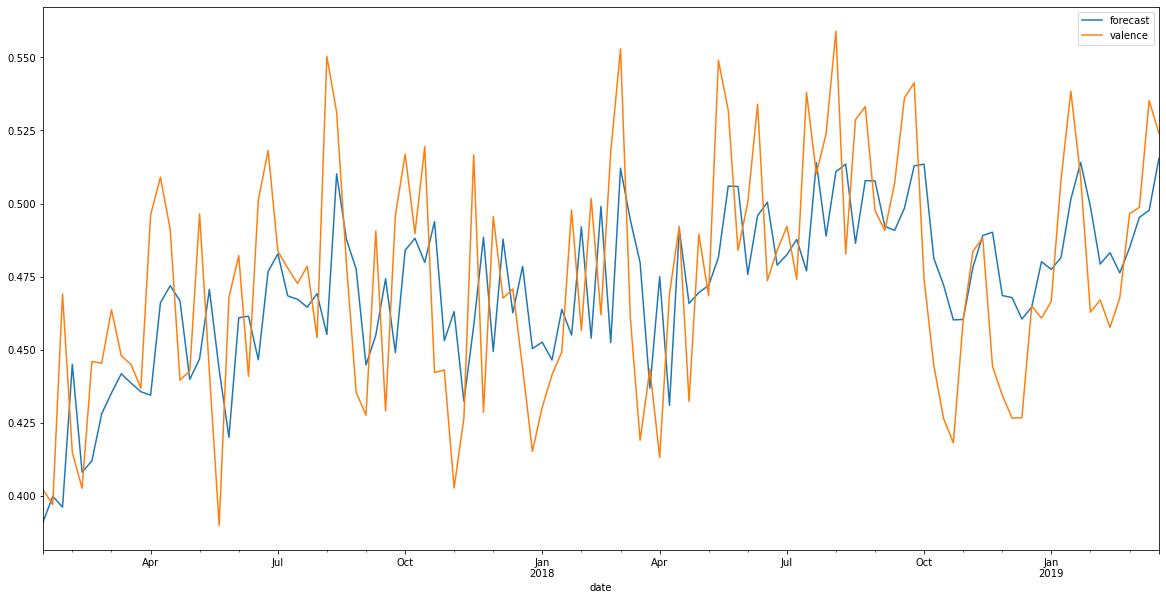

In [64]:
fig, ax = plt.subplots(figsize=(20,10))
fig = model_valence_fit.plot_predict(dynamic=False, ax=ax)
plt.show()

### ACF & PACF Plots to Help Choose Best `p` and `q` parameters 

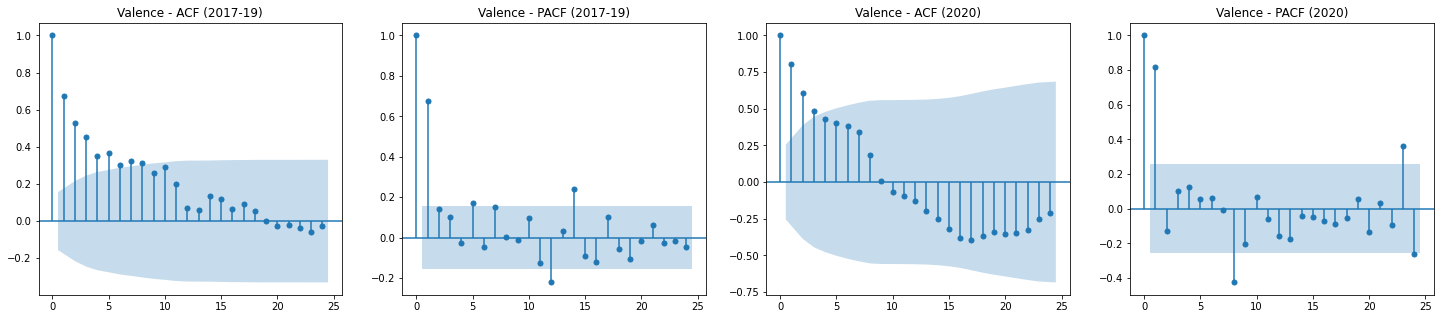

In [136]:
fig,ax = plt.subplots(1, 4, figsize=(25,5))
plot_acf(rw_italy_17_19['valence'], lags=24, title='Valence - ACF (2017-19)', ax=ax[0])
plot_pacf(rw_italy_17_19['valence'], lags=24, title='Valence - PACF (2017-19)', ax=ax[1])
plot_acf(rw_italy_20['valence'], lags=24, title='Valence - ACF (2020)', ax=ax[2])
plot_pacf(rw_italy_20['valence'], lags=24, title='Valence - PACF (2020)', ax=ax[3]) ;

#### Once-differenced `ACF` and `PACF` plots 

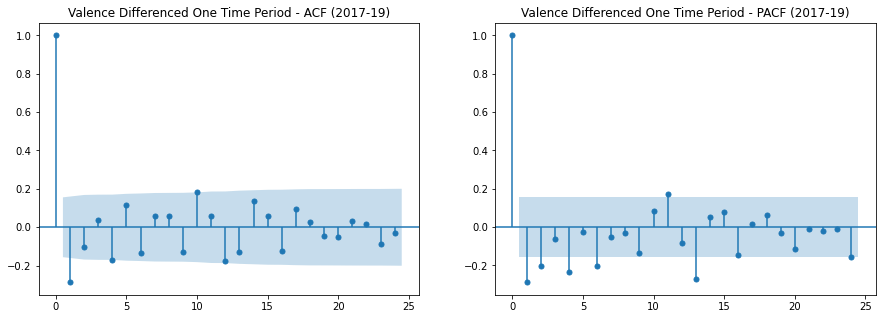

In [135]:
fig,ax = plt.subplots(1, 2, figsize=(15,5))
plot_acf(lag_df['valence_once_differenced'], lags=24, title='Valence Differenced One Time Period - ACF (2017-19)', ax=ax[0])
plot_pacf(lag_df['valence_once_differenced'], lags=24, title='Valence Differenced One Time Period - PACF (2017-19)', ax=ax[1]) ;

### _ARIMA(2,1,0)_

In [119]:
train_valence = rw_italy_17_19['valence'].diff(1).fillna(0)[1:117]
test_valence = rw_italy_17_19['valence'].diff(1).fillna(0)[117::]

In [124]:
train_valence = rw_italy_17_19['valence'][1:117]
test_valence = rw_italy_17_19['valence'][117::]

**I think the problem here is that I need to take differenced data..... if d=1, then I need to use the difference?**

In [125]:
model_valence = ARIMA(train_valence, order=(2,1,0))

model_valence_fit = model_valence.fit()

preds_train_valence_arima_210 = model_valence_fit.predict(start=train_valence.index[1], end=train_valence.index[-1])

preds_test_valence_arima_210 = model_valence_fit.predict(start=test_valence.index[0], end=test_valence.index[-1])

In [126]:
train_valence

date
2017-01-08    0.390494
2017-01-15    0.402156
2017-01-22    0.396994
2017-01-29    0.469083
2017-02-05    0.414801
                ...   
2019-02-24    0.467765
2019-03-03    0.496508
2019-03-10    0.498714
2019-03-17    0.535239
2019-03-24    0.524016
Freq: W-SUN, Name: valence, Length: 116, dtype: float64

In [127]:
preds_train_valence_arima_210

date
2017-01-15    0.001130
2017-01-22   -0.002054
2017-01-29    0.000969
2017-02-05   -0.023944
2017-02-12    0.004927
                ...   
2019-02-24    0.004339
2019-03-03    0.000266
2019-03-10   -0.011364
2019-03-17   -0.005872
2019-03-24   -0.012385
Freq: W-SUN, Length: 115, dtype: float64

Train RMSE - ARIMA(2,1,0): 0.4751761889095463
Test RMSE - ARIMA(2,1,0): 0.5189735566723244


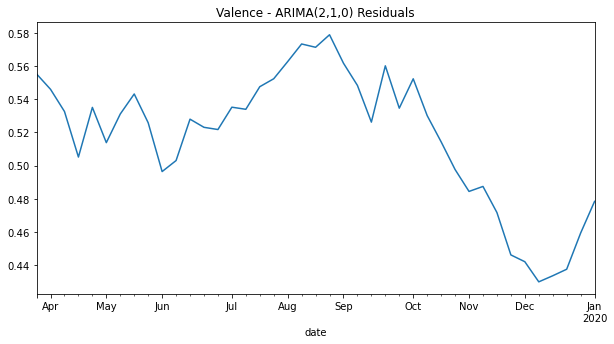

In [128]:
# evaluating the ARIMA(2,1,2) model 

# RMSE 
train_rmse_valence = mean_squared_error(train_valence[1::], preds_train_valence_arima_210)**0.5
print(f'Train RMSE - ARIMA(2,1,0): {train_rmse_valence}')

test_rmse_valence = mean_squared_error(test_valence, preds_test_valence_arima_210)**0.5
print(f'Test RMSE - ARIMA(2,1,0): {test_rmse_valence}')

resids_valence_210 = test_valence - preds_test_valence_arima_210

resids_valence_210.plot(figsize=(10,5))
plt.title("Valence - ARIMA(2,1,0) Residuals");

<AxesSubplot:xlabel='date'>

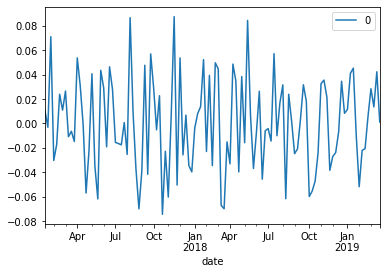

In [142]:
# from video https://www.youtube.com/watch?v=bqvZL8Ww3aA&ab_channel=DataScienceTutorials
residuals_df = pd.DataFrame(model_valence_fit.resid)
residuals_df.plot()

<AxesSubplot:ylabel='Density'>

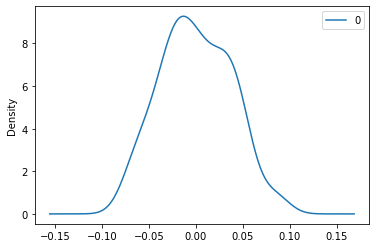

In [143]:
residuals_df.plot(kind='kde')

In [144]:
residuals_df.describe()

,0
count,115.000000
mean,0.000037
std,0.037308
min,-0.074463
25%,-0.025058
50%,-0.003108
75%,0.029303
max,0.087586


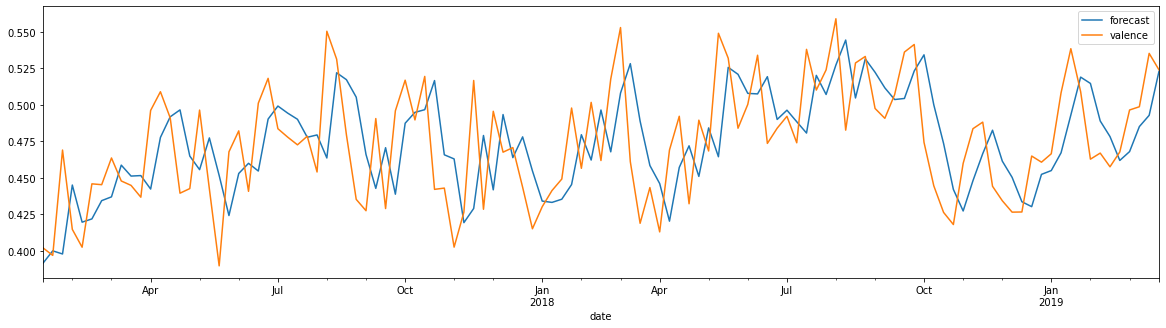

In [145]:
fig, ax = plt.subplots(figsize=(20,5))
fig = model_valence_fit.plot_predict(dynamic=False, ax=ax)
plt.show()

In [138]:
from pandas.plotting import autocorrelation_plot
from matplotlib import pyplot
%matplotlib inline

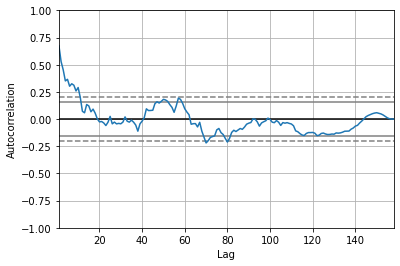

In [140]:
autocorrelation_plot(rw_italy_17_19['valence']) ; 

In [146]:
rw_greece_17_19.columns

Index(['Position', 'danceability', 'energy', 'key', 'loudness', 'mode',
       'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'duration_ms', 'time_signature'],
      dtype='object')

### Building and comparing several ARIMA models 

In [147]:
seven_features = ['danceability', 'energy',  'loudness', 'mode', 'acousticness', 'valence', 'tempo']